In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 300)

from ipywidgets import interact
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("/kaggle/input/abalone-dataset/abalone.csv")

# EDA 

In [3]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.514,0.225,0.101,0.150,15
1,M,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7
2,F,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9
3,M,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10
4,I,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7


In [4]:
df.duplicated().sum()

0

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,4177.000,0.524,0.120,0.075,0.450,0.545,0.615,0.815
Diameter,4177.000,0.408,0.099,0.055,0.350,0.425,0.480,0.650
Height,4177.000,0.140,0.042,0.000,0.115,0.140,0.165,1.130
Whole weight,4177.000,0.829,0.490,0.002,0.442,0.799,1.153,2.825
Shucked weight,4177.000,0.359,0.222,0.001,0.186,0.336,0.502,1.488
Viscera weight,4177.000,0.181,0.110,0.001,0.093,0.171,0.253,0.760
Shell weight,4177.000,0.239,0.139,0.002,0.130,0.234,0.329,1.005
Rings,4177.000,9.934,3.224,1.000,8.000,9.000,11.000,29.000


I created a new column called "age" by adding 1.5 to the number of rings and then dropped the Rings , because it is no longer useful to our case.

In [6]:
 df['age'] = df['Rings']+1.5
 df.drop('Rings', axis = 1, inplace = True)

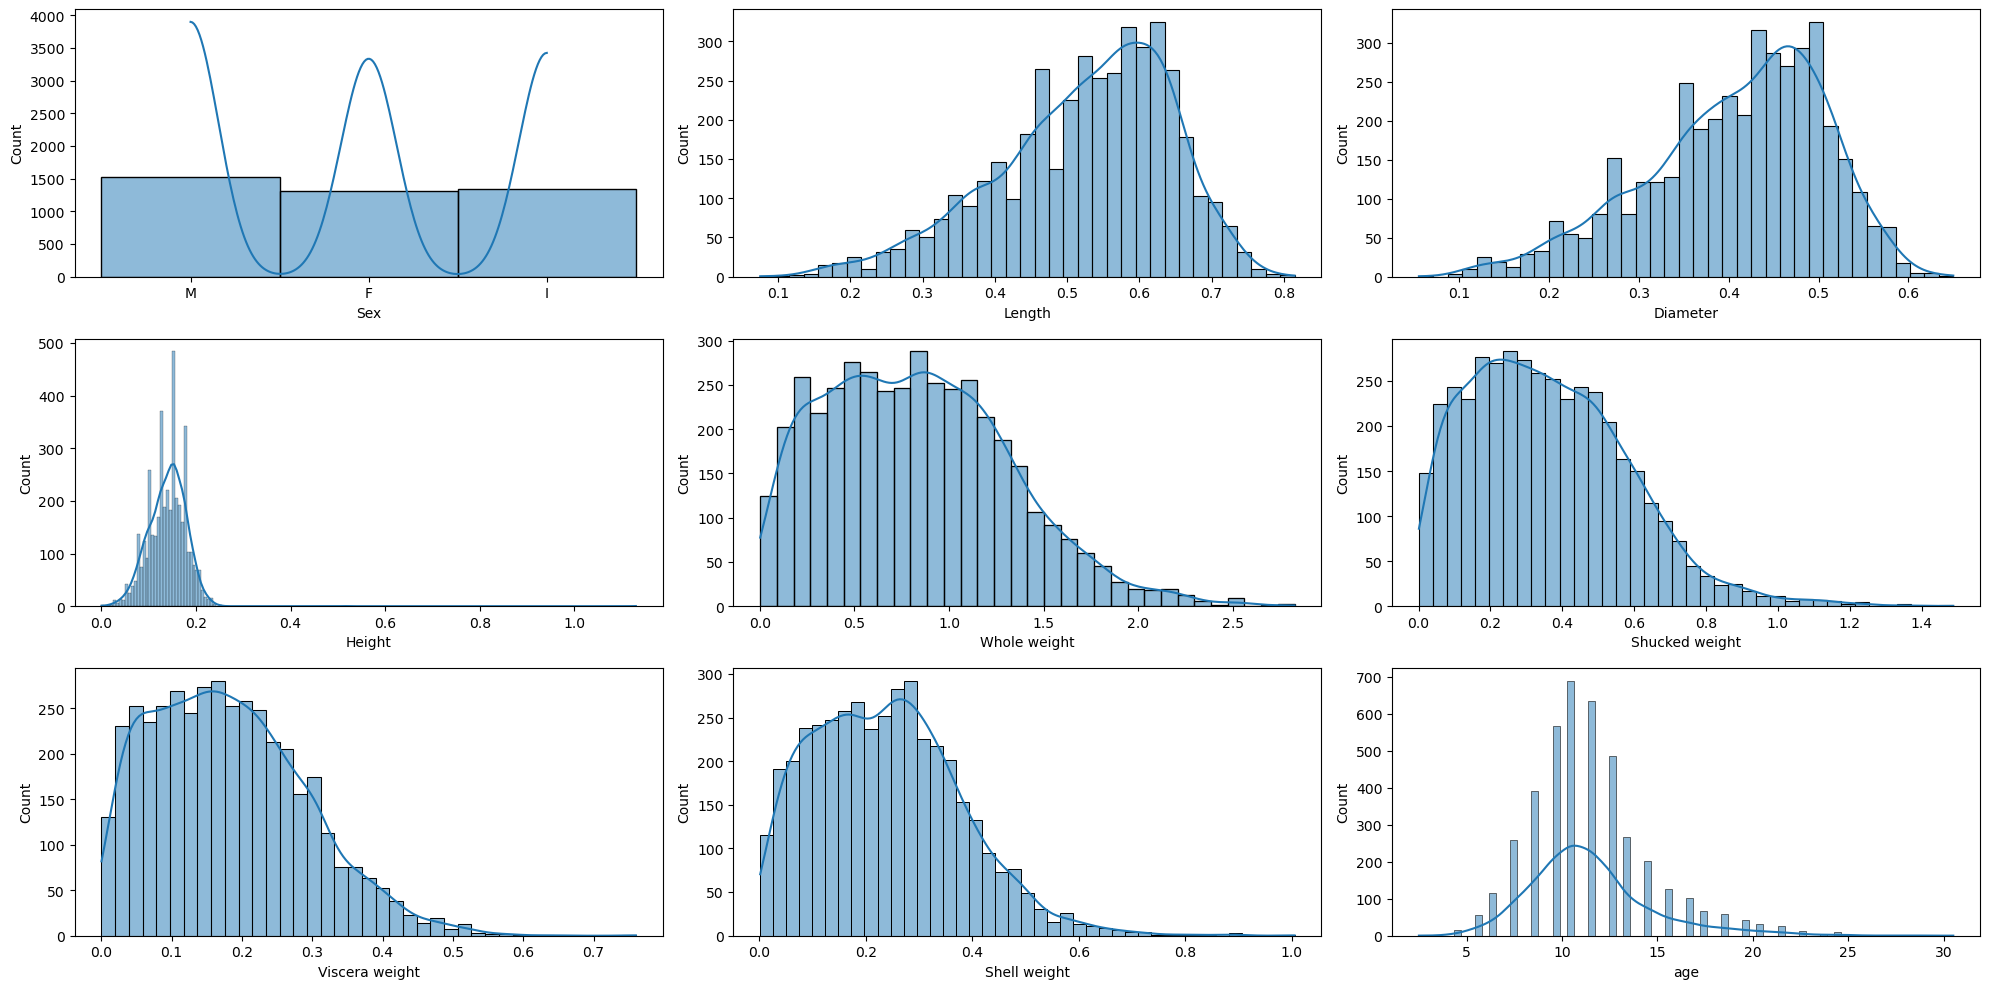

In [7]:
fig = plt.figure(figsize=(20,10))
for i, col in enumerate(df.columns):
        plt.subplot(3,3,i+1)
        sns.histplot(df[col], kde=True)
plt.tight_layout();


<Axes: >

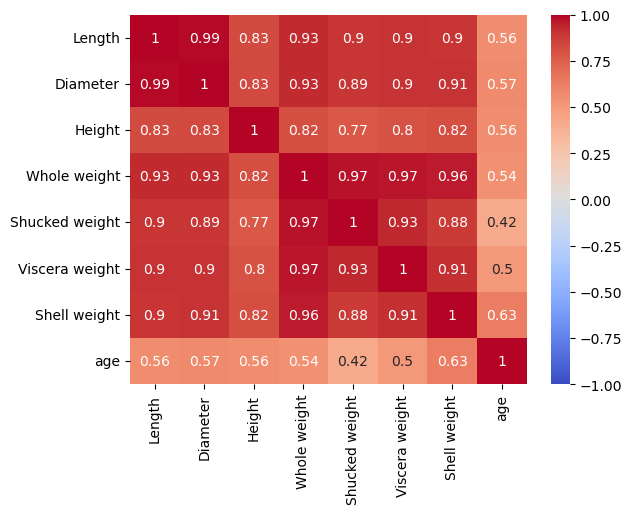

In [8]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")

<Axes: xlabel='age'>

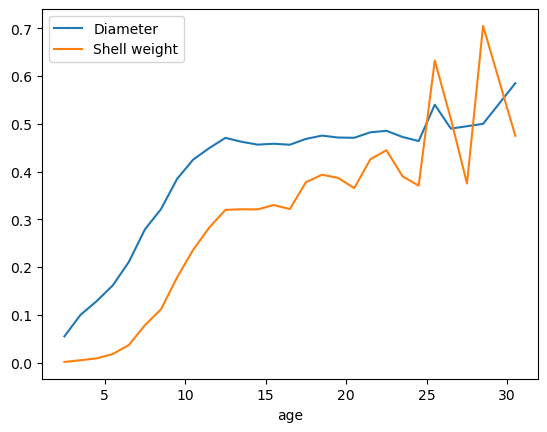

In [9]:
df.groupby(["age"])["Diameter","Shell weight"].mean().plot(kind='line')

<Axes: ylabel='Sex'>

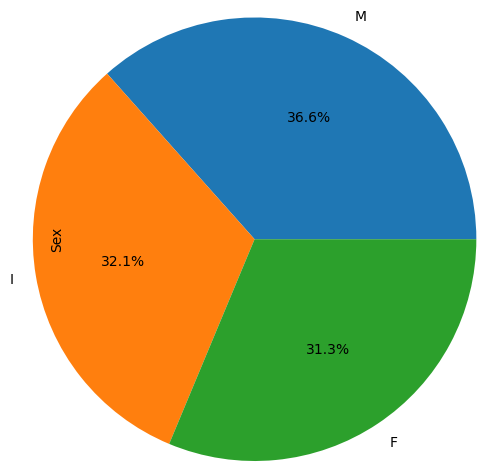

In [10]:
df.Sex.value_counts().plot(kind="pie", autopct='%1.1f%%', radius=1.5)


In [11]:
df.groupby(["Sex"])["age"].mean()

Sex
F   12.629
I    9.390
M   12.205
Name: age, dtype: float64

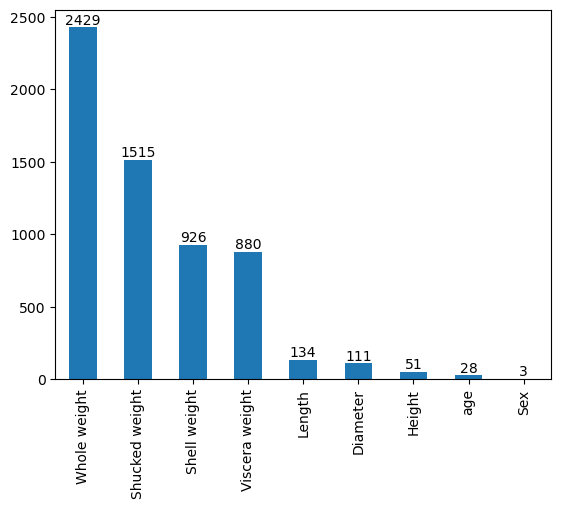

In [12]:
ax = df.nunique().sort_values(ascending=False).plot(kind='bar')
ax.bar_label(ax.containers[0]);


<Axes: >

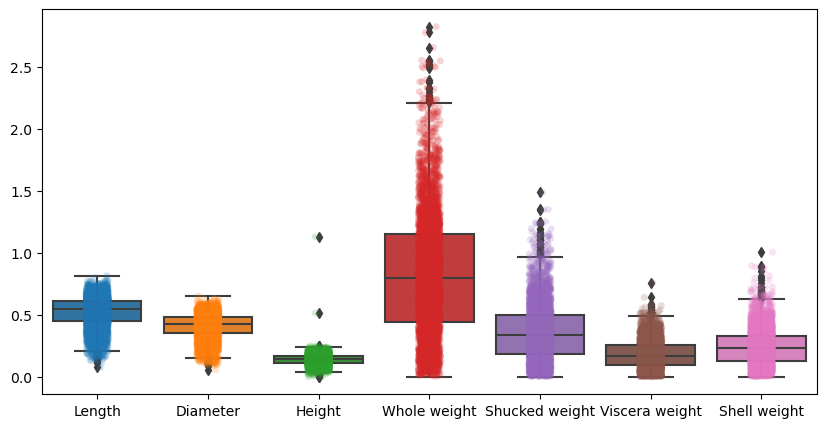

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df.drop("age", axis=1))
sns.stripplot(data=df.drop("age", axis=1), alpha=.2)

In [14]:
def column_box(col):
    sns.boxplot(data = df,
                y= df[col], 
                x=df["age"], 
                palette='bright')
cols = df.columns[:-1]
interact(column_box, col=cols),
interact(column_box, col=cols);

interactive(children=(Dropdown(description='col', options=('Sex', 'Length', 'Diameter', 'Height', 'Whole weigh…

interactive(children=(Dropdown(description='col', options=('Sex', 'Length', 'Diameter', 'Height', 'Whole weigh…

<Axes: xlabel='Shell weight', ylabel='age'>

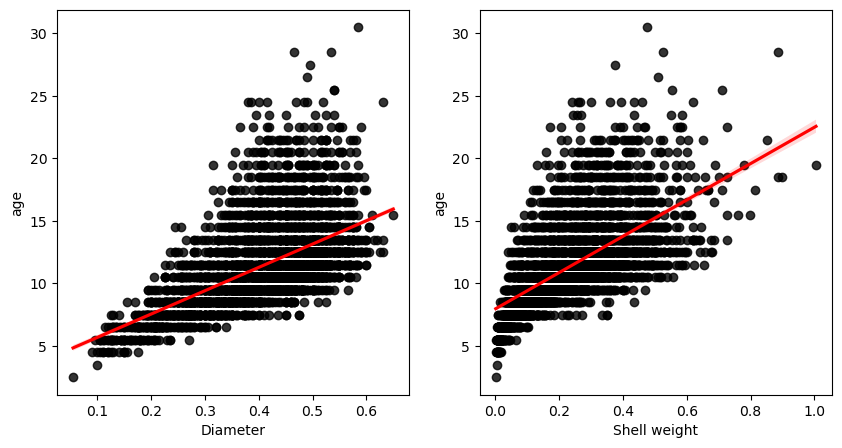

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.regplot(ax=ax[0], data=df, x="Diameter", y="age", scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(ax=ax[1], data=df, x="Shell weight", y="age", scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [16]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
age               float64
dtype: object

# Preprocessing 

In [17]:
X = df.drop("age", axis=1)
y = df.age

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
scaler = StandardScaler()

In [20]:
X.select_dtypes(include="O").columns

Index(['Sex'], dtype='object')

In [21]:
from sklearn.compose import make_column_transformer

In [22]:
onehot = OneHotEncoder(handle_unknown="ignore", sparse=False, drop="first").set_output(transform="pandas")
ordenc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cat = X.select_dtypes(include="O").columns
encoder = make_column_transformer((onehot, cat), remainder='passthrough')
dt_encoder = make_column_transformer((ordenc, cat), remainder='passthrough')

# Modelling 

In [23]:
import sklearn
sklearn.metrics.get_scorer_names()


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

## KNN  

In [24]:
knn_mod = Pipeline([("encoder", encoder), ("scaler", scaler), ("knn", KNeighborsRegressor(n_neighbors=5))])
scores = cross_validate(knn_mod,
                        X_train,
                        y_train,
                        cv=5, 
                        scoring=['r2',
                                 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 
                                 'neg_root_mean_squared_error'], 
                        return_train_score=True)

In [25]:
pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              0.472
train_r2                             0.657
test_neg_mean_absolute_error        -1.640
train_neg_mean_absolute_error       -1.331
test_neg_mean_squared_error         -5.486
train_neg_mean_squared_error        -3.577
test_neg_root_mean_squared_error    -2.337
train_neg_root_mean_squared_error   -1.891
dtype: float64

In [26]:
y.mean()

11.433684462532918

In [27]:
knn_model = Pipeline([("encoder", encoder), ("scaler", scaler), ("knn", KNeighborsRegressor())])

param_grid = {"knn__n_neighbors": range(5, 15),
              "knn__p": np.linspace(1, 2, 3),
              "knn__weights": ['uniform']}  # 'distance'

# knn_grid_model = RandomizedSearchCV(knn_model,
#                                     param_grid,
#                                     cv=10, 
#                                     scoring='r2', 
#                                     n_jobs=-1, 
#                                     return_train_score=True)
knn_grid_model = GridSearchCV(knn_model,
                              param_grid,
                              scoring='r2',
                              cv=5,
                              n_jobs=-1, return_train_score=True)

knn_grid_model.fit(X_train, y_train)

knn_grid_model.best_params_

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

{'knn__n_neighbors': 12, 'knn__p': 2.0, 'knn__weights': 'uniform'}

In [28]:
pd.DataFrame(knn_grid_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021,0.007,0.030,0.006,5,1.000,uniform,"{'knn__n_neighbors': 5, 'knn__p': 1.0, 'knn__w...",0.463,0.478,0.490,0.517,0.465,0.483,0.020,28,0.663,0.657,0.660,0.656,0.658,0.659,0.002
1,0.016,0.001,0.099,0.003,5,1.500,uniform,"{'knn__n_neighbors': 5, 'knn__p': 1.5, 'knn__w...",0.468,0.469,0.492,0.509,0.453,0.478,0.020,29,0.661,0.662,0.655,0.654,0.666,0.660,0.005
2,0.016,0.001,0.020,0.001,5,2.000,uniform,"{'knn__n_neighbors': 5, 'knn__p': 2.0, 'knn__w...",0.444,0.462,0.471,0.523,0.461,0.472,0.027,30,0.658,0.659,0.652,0.654,0.661,0.657,0.003
3,0.017,0.002,0.037,0.016,6,1.000,uniform,"{'knn__n_neighbors': 6, 'knn__p': 1.0, 'knn__w...",0.484,0.474,0.487,0.529,0.484,0.492,0.019,25,0.647,0.636,0.644,0.639,0.643,0.642,0.004
4,0.016,0.001,0.129,0.017,6,1.500,uniform,"{'knn__n_neighbors': 6, 'knn__p': 1.5, 'knn__w...",0.481,0.478,0.499,0.544,0.469,0.494,0.027,24,0.645,0.643,0.639,0.638,0.649,0.643,0.004
5,0.016,0.001,0.021,0.001,6,2.000,uniform,"{'knn__n_neighbors': 6, 'knn__p': 2.0, 'knn__w...",0.458,0.471,0.483,0.529,0.476,0.483,0.024,27,0.641,0.641,0.637,0.635,0.636,0.638,0.003
6,0.016,0.000,0.029,0.000,7,1.000,uniform,"{'knn__n_neighbors': 7, 'knn__p': 1.0, 'knn__w...",0.498,0.485,0.492,0.525,0.476,0.495,0.016,22,0.632,0.626,0.629,0.626,0.629,0.629,0.002
7,0.015,0.000,0.107,0.005,7,1.500,uniform,"{'knn__n_neighbors': 7, 'knn__p': 1.5, 'knn__w...",0.473,0.480,0.499,0.542,0.478,0.495,0.025,23,0.633,0.623,0.626,0.623,0.631,0.627,0.004
8,0.018,0.002,0.020,0.000,7,2.000,uniform,"{'knn__n_neighbors': 7, 'knn__p': 2.0, 'knn__w...",0.463,0.476,0.491,0.550,0.475,0.491,0.031,26,0.628,0.622,0.627,0.617,0.623,0.624,0.004
9,0.016,0.000,0.030,0.001,8,1.000,uniform,"{'knn__n_neighbors': 8, 'knn__p': 1.0, 'knn__w...",0.485,0.494,0.496,0.535,0.478,0.498,0.020,21,0.620,0.615,0.617,0.612,0.615,0.616,0.003


In [29]:
pd.DataFrame(knn_grid_model.cv_results_).loc[knn_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score    0.507
mean_train_score   0.586
Name: 23, dtype: object

In [30]:
test_error_rates = []

for k in range(1,30):
    
    operations = [("encoder", encoder), ("scaler", scaler),  ("knn", KNeighborsRegressor(n_neighbors=k))]

    knn_pipe_model = Pipeline(steps=operations)
    
    scores = cross_validate(knn_pipe_model,
                            X_train,
                            y_train,
                            scoring=['r2'],
                            cv=10,
                            n_jobs=-1)
     
    r2_mean = scores["test_r2"].mean() 
    
    test_error = 1 - r2_mean
    
    test_error_rates.append(test_error)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Text(0, 0.5, 'Error Rate')

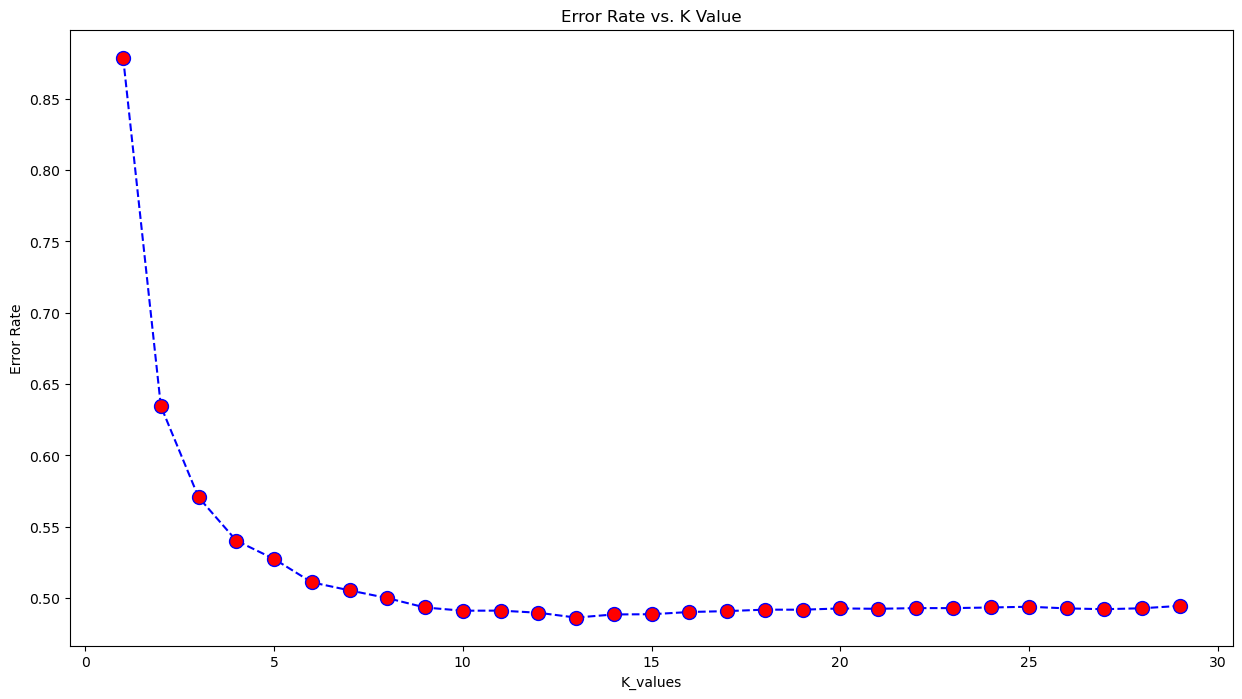

In [31]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')

In [32]:
knn_mod = Pipeline([("encoder", encoder), ("scaler", scaler), ("knn", KNeighborsRegressor(n_neighbors=12))])
scores = cross_validate(knn_mod,
                        X_train,
                        y_train,
                        cv=10, 
                        scoring=['r2',
                                 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 
                                 'neg_root_mean_squared_error'], 
                        return_train_score=True)

pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              0.510
train_r2                             0.589
test_neg_mean_absolute_error        -1.568
train_neg_mean_absolute_error       -1.439
test_neg_mean_squared_error         -5.082
train_neg_mean_squared_error        -4.287
test_neg_root_mean_squared_error    -2.247
train_neg_root_mean_squared_error   -2.070
dtype: float64

## Ridge 

In [33]:
from sklearn.linear_model import Ridge

In [34]:
ridge_mod = Pipeline([("encoder", encoder), ("scaler", scaler), ("Ridge", Ridge())])
scores = cross_validate(ridge_mod,
                        X_train,
                        y_train,
                        cv=10, 
                        scoring=['r2',
                                 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 
                                 'neg_root_mean_squared_error'], 
                        return_train_score=True)

pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              0.516
train_r2                             0.535
test_neg_mean_absolute_error        -1.597
train_neg_mean_absolute_error       -1.587
test_neg_mean_squared_error         -5.017
train_neg_mean_squared_error        -4.847
test_neg_root_mean_squared_error    -2.231
train_neg_root_mean_squared_error   -2.202
dtype: float64

In [35]:
alpha_space = np.linspace(.5, 2, 100)
alpha_space
param_grid = {"ridge__alpha": alpha_space}

model = Pipeline([("encoder", encoder), ("scaler", scaler), ("ridge", Ridge())])
grid_ridge = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='r2',
                          cv=10,
                          verbose=2,
                          n_jobs=-1,
                          return_train_score=True)

grid_ridge.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

[CV] END ...................................ridge__alpha=0.5; total time=   0.0s
[CV] END ...................................ridge__alpha=0.5; total time=   0.0s
[CV] END ....................ridge__alpha=0.5151515151515151; total time=   0.0s
[CV] END ....................ridge__alpha=0.5151515151515151; total time=   0.0s
[CV] END ....................ridge__alpha=0.5151515151515151; total time=   0.0s
[CV] END ....................ridge__alpha=0.5151515151515151; total time=   0.0s
[CV] END ....................ridge__alpha=0.5303030303030303; total time=   0.0s
[CV] END ....................ridge__alpha=0.5303030303030303; total time=   0.0s
[CV] END ....................ridge__alpha=0.5303030303030303; total time=   0.0s
[CV] END ....................ridge__alpha=0.5303030303030303; total time=   0.0s
[CV] END ....................ridge__alpha=0.5606060606060606; total time=   0.0s
[CV] END ....................ridge__alpha=0.5606060606060606; total time=   0.0s
[CV] END ...................

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

[CV] END ....................ridge__alpha=1.0757575757575757; total time=   0.0s
[CV] END .....................ridge__alpha=1.106060606060606; total time=   0.0s
[CV] END .....................ridge__alpha=1.106060606060606; total time=   0.0s
[CV] END .....................ridge__alpha=1.121212121212121; total time=   0.0s
[CV] END .....................ridge__alpha=1.121212121212121; total time=   0.0s
[CV] END .....................ridge__alpha=1.121212121212121; total time=   0.0s
[CV] END .....................ridge__alpha=1.121212121212121; total time=   0.0s
[CV] END .....................ridge__alpha=1.121212121212121; total time=   0.0s
[CV] END .....................ridge__alpha=1.121212121212121; total time=   0.0s
[CV] END ....................ridge__alpha=1.1666666666666667; total time=   0.0s
[CV] END ....................ridge__alpha=1.1666666666666667; total time=   0.0s
[CV] END ....................ridge__alpha=1.1666666666666667; total time=   0.0s
[CV] END ...................

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         Index(['Sex'], dtype='object'))])),
                                       ('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.5       , 0.51515152, 0.53030303, 0.54...
       1.56060606, 1.57575758, 1.59090909, 1.60606061, 1.62121212,
       1.63636364, 1.65151515, 1.66666667, 1.68181818, 1.6969697 ,
       1.71212121, 1.72727273, 1.74242424, 1.75757576, 1.77272727,
       1.78787879, 1.8030303 , 1.81818182, 1.83333333, 1.84848485,
       1.86363636, 1.87878788, 1.89393939, 1.90909091, 1.92424242,
       1.93939394, 1.95454545, 1.96969697, 1.98484848, 2.        ])},
             return_train_score=True, scoring='r2', verbose=2)

In [36]:
grid_ridge.best_estimator_

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Sex'], dtype='object'))])),
                ('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=1.5151515151515151))])

In [37]:
grid_ridge.best_params_

{'ridge__alpha': 1.5151515151515151}

In [38]:
pd.DataFrame(grid_ridge.cv_results_).loc[grid_ridge.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score    0.516
mean_train_score   0.535
Name: 67, dtype: object

## DT 

In [39]:
dt_mod = Pipeline([("encoder", dt_encoder), ("DT", DecisionTreeRegressor())])
scores = cross_validate(dt_mod,
                        X_train,
                        y_train,
                        cv=5, 
                        scoring=['r2',
                                 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 
                                 'neg_root_mean_squared_error'], 
                        return_train_score=True)

pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                              0.075
train_r2                             1.000
test_neg_mean_absolute_error        -2.130
train_neg_mean_absolute_error        0.000
test_neg_mean_squared_error         -9.496
train_neg_mean_squared_error         0.000
test_neg_root_mean_squared_error    -3.081
train_neg_root_mean_squared_error    0.000
dtype: float64

In [40]:
params = {
    "DT__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "DT__max_depth": [4],
    "DT__min_samples_split": [3, 4],
    "DT__min_samples_leaf": [1, 2,],
    "DT__max_leaf_nodes": [45, 50]
}

model = Pipeline([("encoder", dt_encoder), ("DT", DecisionTreeRegressor())])

grid_model = GridSearchCV(estimator=model,
                          param_grid=params,
                          scoring="r2",
                          cv=10,
                          return_train_score=True,
                          verbose=1,
                          n_jobs=-1)

grid_model.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Sex'], dtype='object'))])),
                                       ('DT', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'DT__criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson'],
                         'DT__max_depth': [4], 'DT__max_leaf_nodes': [45, 50],
                         'DT__min_samples_leaf': [1, 2],
                         'DT__min_samples_split': [3, 4]},
             return_train_score=True, scoring='r2', verbose=1)

In [41]:
grid_model.best_params_

{'DT__criterion': 'poisson',
 'DT__max_depth': 4,
 'DT__max_leaf_nodes': 45,
 'DT__min_samples_leaf': 2,
 'DT__min_samples_split': 3}

In [42]:
pd.DataFrame(grid_model.cv_results_).loc[grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score    0.440
mean_train_score   0.497
Name: 26, dtype: object